# Face detection modeller

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import cv2
import dlib
from time import time
import matplotlib.pyplot as plt
import copy
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle("/Users/laurabraadrasmussen/Bachelorprojekt/df_adj_age.pkl")


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8477 entries, 0 to 8476
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Images   8477 non-null   object
 1   Ages     8477 non-null   int64 
 2   Genders  8477 non-null   int64 
 3   Race     8477 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 265.0+ KB
None


In [4]:
## caucasian or not variable
df['Caucasien/Non-caucasian'] = [0 if ele  == 0 else 1 for ele in df["Race"]]
#df.drop(df[df['Race'] == 4].index, inplace = True)
df2 = df[df.Race != 4]
df2 = df2.reset_index(drop=True)

In [5]:
df2

,Images,Ages,Genders,Race,Caucasien/Non-caucasian
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,16,1,3,1
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,40,1,0,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,71,1,0,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,80,1,0,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6,1,2,1
...,...,...,...,...,...
7554,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0,2,1
7555,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0,3,1
7556,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,0,2,1
7557,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,0,0,0


In [6]:
# to array 
images_arr = []
for im in tqdm(range(len(df2))): 
    images_arr.append(np.array(df2['Images'][im]))

  0%|          | 0/7559 [00:00<?, ?it/s]

In [7]:
images_output = []
for i in tqdm(images_arr):
    if len(i.shape) == 2:
        images_output.append(cv2.cvtColor(i, cv2.COLOR_GRAY2BGR))
    else:
        images_output.append(i)

  0%|          | 0/7559 [00:00<?, ?it/s]

## HOG

In [8]:
# Get the HoG face detection model.
hog_face_detector = dlib.get_frontal_face_detector()
hog_face_detector

In [9]:
def hogDetectFaces(image, hog_face_detector, display = True):
    '''
    This function performs face(s) detection on an image using dlib hog face detector.
    Args:
        image:             The input image of the person(s) whose face needs to be detected.
        hog_face_detector: The hog face detection model required to perform the detection on the input image.
        display:           A boolean value that is if set to true the function displays the original input image, 
                           and the output image with the bounding boxes drawn and time taken written and returns nothing.
    Returns:
        output_image: A copy of input image with the bounding boxes drawn.
        results:      The output of the face detection process on the input image.
    '''
    
    # Get the height and width of the input image.
    
    height, width, _ = image.shape
    
    
    # Create a copy of the input image to draw bounding boxes on.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #imgRGB = image
    # Get the current time before performing face detection.
    start = time()

    # Perform the face detection on the image.
    results = hog_face_detector(imgRGB, 0)
    
    
    # Get the current time after performing face detection.
    end = time()
    time_to_detect = round(end - start, 5)
    # Loop through the bounding boxes of each face detected in the image.
    for bbox in results:
        
        # Retrieve the left most x-coordinate of the bounding box.
        x1 = bbox.left()
        
        # Retrieve the top most y-coordinate of the bounding box.
        y1 = bbox.top()
        
        # Retrieve the right most x-coordinate of the bounding box.
        x2 = bbox.right()
        
        # Retrieve the bottom most y-coordinate of the bounding box.       
        y2 = bbox.bottom()

        # Draw a rectangle around a face on the copy of the image using the retrieved coordinates.
        cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)
    
    
    # Check if the original input image and the output image are specified to be displayed.
    if display:
        
        # Write the time take by face detection process on the output image. 
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(2, 30),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        
        # Display the original input image and the output image.
        plt.figure(figsize=[5,5])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    # Otherwise
    else:
        
        # Return the output image and results of face detection.
        return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR), results, time_to_detect

In [10]:
#hogDetectFaces(cv2.cvtColor(images_arr[i], cv2.COLOR_RGB2BGR), hog_face_detector, display = False)


hogfaces = [hogDetectFaces(images_output[i], hog_face_detector, display = False) for i in tqdm(range(len(images_output)))]

  0%|          | 0/7559 [00:00<?, ?it/s]

In [12]:
not_dect_index = [i for i in range(len(hogfaces)) if len(hogfaces[i][1]) == 0]
not_dect_images = [df2['Images'][i] for i in not_dect_index]
not_dect_ages = [df2['Ages'][i] for i in not_dect_index]
not_dect_genders = [df2['Genders'][i] for i in not_dect_index]
not_dect_races = [df2['Race'][i] for i in not_dect_index]
not_dect_caucasian = [df2['Caucasien/Non-caucasian'][i] for i in not_dect_index]
not_dect_time = [pd.Timedelta(hogfaces[i][2], unit='minutes') for i in not_dect_index]

df_not_detected = pd.DataFrame({
    'not_dect_index': not_dect_index,
    'not_dect_images': not_dect_images,
    'not_dect_ages': not_dect_ages,
    'not_dect_genders': not_dect_genders,
    'not_dect_races': not_dect_races,
    'not_dect_caucasian': not_dect_caucasian,
    'not_dect_time': not_dect_time
})

In [13]:
df_not_detected

,not_dect_index,not_dect_images,not_dect_ages,not_dect_genders,not_dect_races,not_dect_caucasian,not_dect_time
0,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,6,1,2,1,0 days 00:00:00.396000
1,5,<PIL.JpegImagePlugin.JpegImageFile image mode=...,54,1,0,0,0 days 00:00:00.294000
2,16,<PIL.JpegImagePlugin.JpegImageFile image mode=...,5,1,2,1,0 days 00:00:00.645000
3,55,<PIL.JpegImagePlugin.JpegImageFile image mode=...,75,1,0,0,0 days 00:00:00.466200
4,75,<PIL.JpegImagePlugin.JpegImageFile image mode=...,8,1,2,1,0 days 00:00:00.801000
...,...,...,...,...,...,...,...
426,7532,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,2,1,0 days 00:00:00.202200
427,7538,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,2,1,0 days 00:00:00.649800
428,7546,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,1,3,1,0 days 00:00:00.199800
429,7550,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,1,2,1,0 days 00:00:00.074400


<AxesSubplot:ylabel='Frequency'>

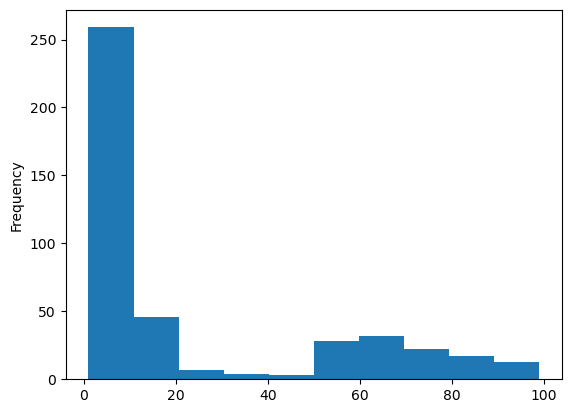

In [14]:
df_not_detected['not_dect_ages'].plot(kind = 'hist')
#print(df_not_detected)

<AxesSubplot:xlabel='not_dect_genders', ylabel='count'>

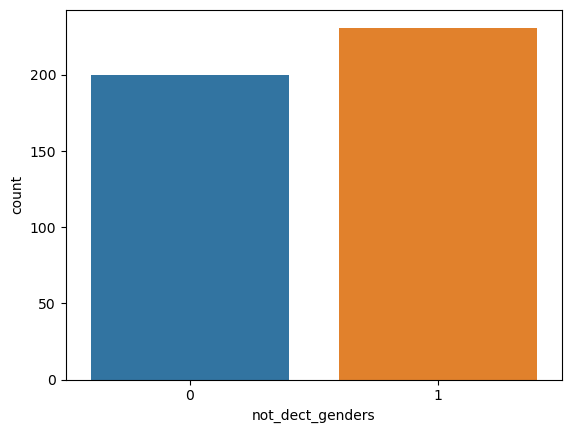

In [15]:
#df_not_detected['not_dect_genders'].plot(kind = 'hist')
sns.countplot(df_not_detected['not_dect_genders'])

<AxesSubplot:xlabel='not_dect_races', ylabel='count'>

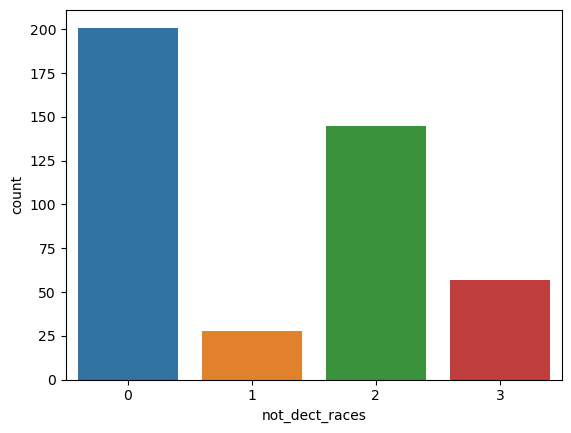

In [16]:
#df_not_detected['not_dect_races'].plot(kind = 'hist')

sns.countplot(df_not_detected['not_dect_races'])

<AxesSubplot:xlabel='not_dect_caucasian', ylabel='count'>

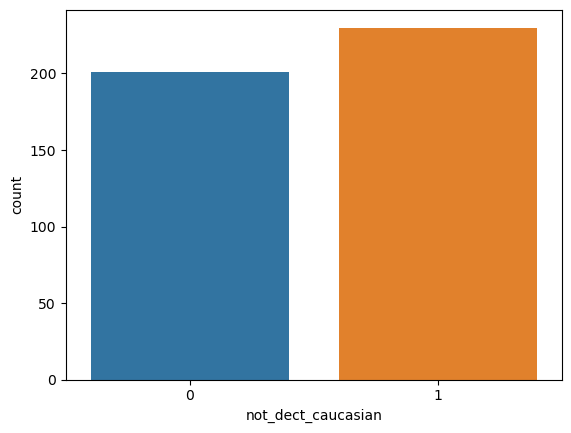

In [17]:
sns.countplot(df_not_detected['not_dect_caucasian'])

## Procent fordeling

### Køn

In [45]:
unique_gender = sorted(pd.unique(df2['Genders']))
percentage_g = []

for i in unique_gender:
    percentage_g.append(((len(df_not_detected[df_not_detected["not_dect_genders"] == i]))/(len(df2[df2["Genders"] == i])))*100)

In [46]:
percentage_g

[5.991611743559018, 5.472636815920398]

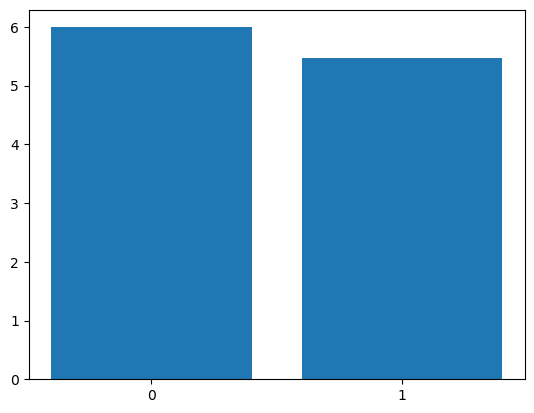

In [47]:
plt.bar(list(unique_gender), percentage_g)
plt.xticks(list(unique_gender))
plt.show()

### Race

In [20]:
unique_race = sorted(pd.unique(df2['Race']))
percentage_r = []

for i in unique_race:
    percentage_r.append(((len(df_not_detected[df_not_detected["not_dect_races"] == i]))/(len(df2[df2["Race"] == i])))*100)

In [21]:
percentage_r

[4.070473876063184, 7.547169811320755, 13.96917148362235, 4.702970297029703]

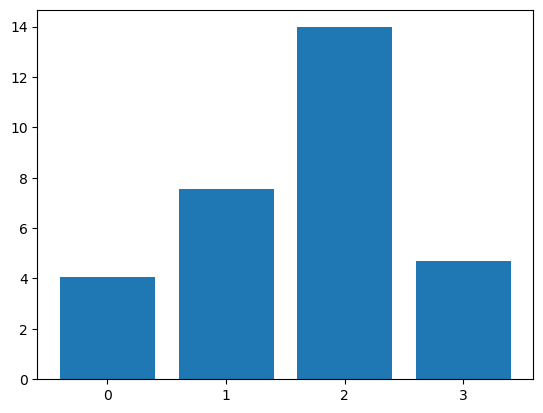

In [33]:
plt.bar(list(unique_race), percentage_r)
plt.xticks(list(unique_race))
plt.show()

### Caucasian

In [37]:
unique_caucasian = sorted(pd.unique(df2['Caucasien/Non-caucasian']))
percentage_c = []

for i in unique_caucasian:
    percentage_c.append(((len(df_not_detected[df_not_detected["not_dect_caucasian"] == i]))/(len(df2[df2["Caucasien/Non-caucasian"] == i])))*100)

In [38]:
percentage_c

[4.070473876063184, 8.77527661198016]

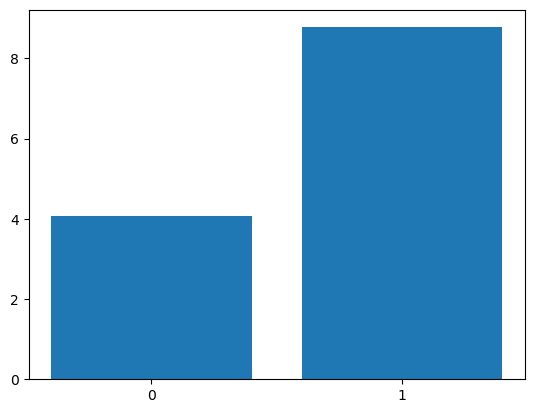

In [40]:
plt.bar(list(unique_caucasian), percentage_c)
plt.xticks(list(unique_caucasian))
plt.show()

### Alder

In [41]:
unique_ages = sorted(pd.unique(df2['Ages']))
percentage_a = []

for i in unique_ages:
    percentage_a.append(((len(df_not_detected[df_not_detected["not_dect_ages"] == i]))/(len(df2[df2["Ages"] == i])))*100)

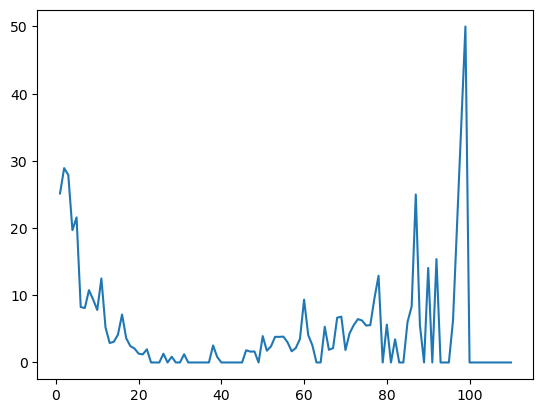

In [42]:
plt.plot(list(unique_ages), percentage_a)
plt.show()

### Tid

In [43]:
df_not_detected.loc[df_not_detected['not_dect_races'] == 0, 'not_dect_time'].mean()

Timedelta('0 days 00:00:01.904877611')

In [44]:
df_not_detected.loc[df_not_detected['not_dect_races'] == 1, 'not_dect_time'].mean()

Timedelta('0 days 00:00:03.653657142')